In [4]:
# !pip install ultralytics

In [5]:
import os
import zipfile
import shutil
import glob
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Aggregation
We will open zips, clean up names, and stack all the training image and label data together.

In [7]:
def strip_prefix(input_dir):
  for fname in os.listdir(input_dir):
    old_path = os.path.join(input_dir, fname)
    if os.path.isfile(old_path) and "-" in fname:
      new_name = fname.split("-", 1)[1]   # take everything after first dash
      new_path = os.path.join(input_dir, new_name)
      os.rename(old_path, new_path)

# -----------------------------------------------------------------------------------
def upload_to_colab(dest_path="/content"):
  uploaded = files.upload()  # opens the picker
  for name, data in uploaded.items():
      out_path = os.path.join(dest_path, name)
      with open(out_path, "wb") as f:
          f.write(data)
      print(f"Saved: {out_path}")

# -----------------------------------------------------------------------------------
def unzip(zip, dest='/content/extracted_files' ):
  with zipfile.ZipFile(zip, 'r') as zip_ref:
    zip_ref.extractall(dest)
  print(f"Successfully extracted '{zip}' to '{dest}'")

# -----------------------------------------------------------------------------------
def zip_and_download(inputs, zip_name="RoofAreaModel.zip"):
  """
  input: list of file paths
  output: zip file
  """
  zip_path = f"/content/{zip_name}"
  with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for path in inputs:
      path = path.rstrip("/")
      if os.path.isdir(path):
        # zip whole directory
        for root, dirs, files_in_dir in os.walk(path):
          for file in files_in_dir:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, "/content")
            z.write(full_path, rel_path)
      elif os.path.isfile(path):
        # zip single file
        rel_path = os.path.relpath(path, "/content")
        z.write(path, rel_path)
      else:
        print(f"Skipping (not found): {path}")

  print(f"Created zip: {zip_path}")
  files.download(zip_path)



In [8]:
# uploading the labelled data to /content in colab
upload_to_colab()

KeyboardInterrupt: 

Successfully extracted '/content/roofArea_ModelArtifacts.zip' to '/content/models'


In [ ]:
# # zipping individual lablled datasets
# all_zips = glob.glob("/content/*.zip")
# for zip_file_path in all_zips:
#   # Get the base name of the zip file (e.g., '30_chunk1_completed.zip')
#   base_name = os.path.basename(zip_file_path)
#   # Get the name without the .zip extension (e.g., '30_chunk1_completed')
#   folder_name = os.path.splitext(base_name)[0]
#   unzip(zip_file_path, dest=f'/content/extracted_files/{folder_name}')

Successfully extracted '/content/30_chunk1_completed.zip' to '/content/extracted_files/30_chunk1_completed'
Successfully extracted '/content/F_chunk1_completed.zip' to '/content/extracted_files/F_chunk1_completed'
Successfully extracted '/content/E_chunk3_completed.zip' to '/content/extracted_files/E_chunk3_completed'
Successfully extracted '/content/F_chunk3_completed.zip' to '/content/extracted_files/F_chunk3_completed'
Successfully extracted '/content/N_chunk1_completed.zip' to '/content/extracted_files/N_chunk1_completed'
Successfully extracted '/content/E_chunk1_completed.zip' to '/content/extracted_files/E_chunk1_completed'
Successfully extracted '/content/E_chunk2_completed .zip' to '/content/extracted_files/E_chunk2_completed '
Successfully extracted '/content/F_chunk2_completed.zip' to '/content/extracted_files/F_chunk2_completed'
Successfully extracted '/content/E_chunk4_completed.zip' to '/content/extracted_files/E_chunk4_completed'


In [ ]:
def merge_labeled_sets(set_paths, output_root="mega_dataset"):
    """
    Merge multiple labeled datasets into a single 'mega_dataset'.
    - Prevents name collisions by prefixing files with a simplified set identifier.
    """

    images_out = os.path.join(output_root, "images")
    labels_out = os.path.join(output_root, "labels")

    # Create output directories if they don't exist
    os.makedirs(images_out, exist_ok=True)
    os.makedirs(labels_out, exist_ok=True)

    for set_path in set_paths:
        # Extract the full name of the dataset chunk folder (e.g., 'E_chunk1_completed')
        full_set_name = os.path.basename(set_path.rstrip("/"))
        # Extract city prefix (e.g., 'E' or '30') from full dataset name
        # This assumes the prefix is the 1st part before the first _
        city_prefix = full_set_name.split('_')[0]
        print(f"Merging {full_set_name} with prefix '{city_prefix}': ")

        imgs_in = os.path.join(set_path, "images")
        lbls_in = os.path.join(set_path, "labels")

        # Process images
        for img_file in glob.glob(os.path.join(imgs_in, "*")):
            base = os.path.basename(img_file) # name of image and its label
            # New image name will be '<city_prefix>_original_name.ext'
            new_img = f"{city_prefix}_{base}"

            shutil.copy(img_file, os.path.join(images_out, new_img))

            # Find and copy the matching label file from OG labels folder
            label_name = os.path.splitext(base)[0] + ".txt"
            label_path = os.path.join(lbls_in, label_name)
            if os.path.exists(label_path):
                # New label name will be '<city_prefix>_original_name.txt'
                new_lbl = f"{city_prefix}_{label_name}"
                # move respective labels txt to MErged folder's labels
                shutil.copy(label_path, os.path.join(labels_out, new_lbl))

    print("Merged dataset created successfully!")

# -------------------------------------------------------------------------------
def list_dataset_folders(root="/content/dataset_sets"):
    """
    Return a list of all labeled dataset folders inside root.
    Folders must each contain 'images' and 'labels' subdirectories.
    """
    folders = []
    for entry in os.listdir(root):
        path = os.path.join(root, entry)
        # Check if it's a directory and contains both 'images' and 'labels' folders
        if os.path.isdir(path) and \
           os.path.isdir(os.path.join(path, "images")) and \
           os.path.isdir(os.path.join(path, "labels")):
            folders.append(path)
    return folders

In [ ]:
# lets join the individual labelled datasets into one MEGASET
# i hope the names dont collide

# list of all individual labelled dataset folder names
set_paths = list_dataset_folders(root="/content/extracted_files")

# merge folders in set_path
merge_labeled_sets(set_paths)
# print(set_paths)

Merging E_chunk5_completed with prefix 'E': 
Merging F_chunk3_completed with prefix 'F': 
Merging N_chunk1_completed with prefix 'N': 
Merging 30_chunk1_completed with prefix '30': 
Merging E_chunk4_completed with prefix 'E': 
Merging F_chunk2_completed with prefix 'F': 
Merging E_chunk3_completed with prefix 'E': 
Merging F_chunk1_completed with prefix 'F': 
Merging E_chunk2_completed with prefix 'E': 
Merged dataset created successfully!


In [ ]:
def split_train_val(
    input_root="mega_dataset",
    output_root="yolo_dataset",
    val_size=0.1,
    seed=42
):
    """Create YOLO train/val folders for segmentation."""

    img_in = os.path.join(input_root, "images")
    lbl_in = os.path.join(input_root, "labels")

    images = sorted(glob.glob(os.path.join(img_in, "*")))
    train_imgs, val_imgs = train_test_split(
        images, test_size=val_size, random_state=seed
    )

    # create folder tree
    for p in [
        "images/train","images/val",
        "labels/train","labels/val"
    ]:
        os.makedirs(os.path.join(output_root, p), exist_ok=True)

    def copy_pairs(img_list, split):
        for img_path in img_list:
            base = os.path.basename(img_path)
            stem = os.path.splitext(base)[0]
            lbl_path = os.path.join(lbl_in, stem + ".txt")

            shutil.copy(img_path, os.path.join(output_root, f"images/{split}", base))
            if os.path.exists(lbl_path):
                shutil.copy(lbl_path, os.path.join(output_root, f"labels/{split}", stem + ".txt"))

    copy_pairs(train_imgs, "train")
    copy_pairs(val_imgs, "val")

    print(f"Train Test split is in '{output_root}'.")

In [ ]:
# split dataset for train and split
# it should be like
# yolo_dataset
# > images > train/, val/
# > labels > train/, val/

split_train_val()

Train Test split is in 'yolo_dataset'.


In [ ]:
def build_yolo_yaml(output_root="yolo_dataset", yaml_name="data.yaml"):
    """Create YOLO segmentation config file."""

    yaml_path = os.path.join(output_root, yaml_name)
    content = f"""
path: {output_root}

train: images/train
val: images/val

names:
  0: PV
  1: roof
""".strip()

    with open(yaml_path, "w") as f:
        f.write(content)

    print(f"YAML is in {yaml_path}")

In [ ]:
build_yolo_yaml()

YAML is in yolo_dataset/data.yaml


In [ ]:
# does yolo comman work
# yolo
# !pip install ultralytics
# !yolo

In [ ]:
!yolo task=segment mode=train \
     model=yolov8s-seg.pt \
     data=/content/yolo_dataset/data.yaml \
     epochs=40 imgsz=640

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

# Area Calculations

In [ ]:


# extracted_root = '/content/extracted_files'

# for fol in os.listdir(extracted_root):
#     dataset = os.path.join(extracted_root, fol)

#     if os.path.isdir(dataset):
#         print(f"Processing folder: {fol}")
#         for item_name in os.listdir(dataset):
#             item_path = os.path.join(dataset, item_name)

#             if os.path.isdir(item_path):
#                 if "images" in item_name.lower() and item_name != "images":
#                     new_path = os.path.join(dataset, "images")
#                     os.rename(item_path, new_path)

#                 elif "labels" in item_name.lower() and item_name != "labels":
#                     new_path = os.path.join(dataset, "labels")
#                     os.rename(item_path, new_path)

#                 else:
#                     print(f"  Skipping '{item_name}' ")


Processing folder: E_chunk5_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: F_chunk3_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: N_chunk1_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: .ipynb_checkpoints
Processing folder: 30_chunk1_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: E_chunk4_completed
Processing folder: F_chunk2_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: E_chunk3_completed
Processing folder: F_chunk1_completed
  Skipping 'images' 
  Skipping 'labels' 
Processing folder: E_chunk2_completed


In [ ]:

# count files

!ls -l mega_dataset/images | grep -v ^d | wc -l
!ls -l mega_dataset/labels | grep -v ^d | wc -l

1036
836


In [ ]:
# listing first five files

!ls mega_dataset/images | tail -n 5
!ls mega_dataset/labels | tail -n 5

N_eea6b429-tile_87.png
N_f11afc34-tile_21.png
N_f69a1851-tile_49.png
N_fa258cd3-tile_78.png
N_fc2a847b-tile_15.png
N_eea6b429-tile_87.txt
N_f11afc34-tile_21.txt
N_f69a1851-tile_49.txt
N_fa258cd3-tile_78.txt
N_fc2a847b-tile_15.txt


In [ ]:
# zip_and_download(["/content/mega_dataset"])
zip_and_download(["/content/runs", "/content/models"], zip_name="roofArea_ModelArtifacts.zip")

Created zip: /content/roofArea_ModelArtifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Area Calculations DIS ONE LOUISE
### Masking, Conversions, Testing the trained model

In [9]:
# Upload Model to colab content folder
upload_to_colab()


Saving roofArea_ModelArtifacts.zip to roofArea_ModelArtifacts.zip
Saved: /content/roofArea_ModelArtifacts.zip


In [10]:

# unzipping model artifacts
unzip("/content/roofArea_ModelArtifacts.zip", dest="/content")

Successfully extracted '/content/roofArea_ModelArtifacts.zip' to '/content'


In [11]:
# lets test out model
# initiate model
m = YOLO('/content/runs/segment/train/weights/best.pt')

In [12]:

# business logic: Concersion rules
# AZ: 0.5 meters per pixel, MI: 1 foot per pixels
# using feet
onefootinmeters = 3.28084

CITY_RULES = {
    "AZ": 0.5 * onefootinmeters
    , "MI": 1.0
}


In [48]:
def find_roof_shapes(predicted, og_size = (256, 256)):
  # IN: predicted is instance of ultralytics.engine.results.Results

  pixels = 0

  if predicted.masks is None:
    return 0
  for mask, class_id in zip(predicted.masks.data, predicted.boxes.cls):
    if int(class_id) == 1:
      # get tensor from memory
      roof_px = mask.cpu()
      # ok thats giving us probabilities, so convert it
      roof_px = (roof_px > 0.5).float()

      # um is yolo changing size of image??
      # area is much to high, i think
      # change image size back to 256 for good measure
      # roof_px_resized = cv2.resize(roof_px.numpy(), og_size)
      pixels += np.sum(roof_px.numpy())

  return pixels


In [49]:
def roofarea(img_path, city):
  # get city conversion rule
  conversion = CITY_RULES[city]

  # yolo predict (roof shapes), get results object
  predicted = m.predict(img_path, save=False)[0]

  # get all the roof pixels
  px = find_roof_shapes(predicted)

  # find real life area of all roof pixels
  # conversion ft squared times all pixels
  a_sqft = px * (conversion ** 2)
  return a_sqft


In [50]:

def test_single_image():
    print("Upload a 256x256 tile:")
    uploaded = files.upload()
    file = list(uploaded.keys())[0]

    city = input("Enter city (AZ or MI): ").strip().upper()

    area = roofarea(file, city)
    print(f"\nEstimated Roof Area: {area:.2f} sq ft")


In [52]:
test_single_image()

Upload a 256x256 tile:


Saving 0c2ae843-tile_11.png to 0c2ae843-tile_11 (8).png
Enter city (AZ or MI): AZ

image 1/1 /content/0c2ae843-tile_11 (8).png: 640x640 2 roofs, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

Estimated Roof Area: 357601.34 sq ft


ultralytics documentation


In [28]:
import matplotlib.pyplot as plt
import cv2

pred = m.predict("/content/0c2ae843-tile_11 (2).png", save=True)



image 1/1 /content/0c2ae843-tile_11 (2).png: 640x640 2 roofs, 8.9ms
Speed: 3.7ms preprocess, 8.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/segment/predict


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

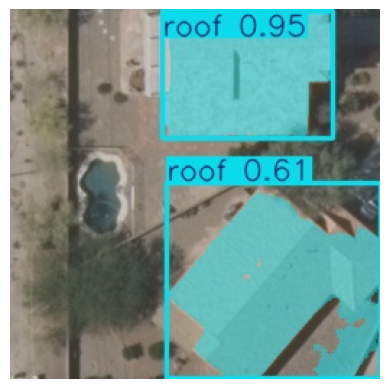

In [31]:
img = cv2.imread("runs/segment/predict/0c2ae843-tile_11 (2).jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [30]:
ls -la "runs/segment/predict"


total 36
drwxr-xr-x 2 root root  4096 Dec  6 15:27  ./
drwxr-xr-x 4 root root  4096 Dec  6 15:27  ../
-rw-r--r-- 1 root root 26590 Dec  6 15:27 '0c2ae843-tile_11 (2).jpg'
